## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [2]:
import pandas as pd
import numpy  as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid', context='talk')

In [116]:
df = pd.read_csv("data/train.csv")

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Exploration

In [111]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.shape

(404290, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [64]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

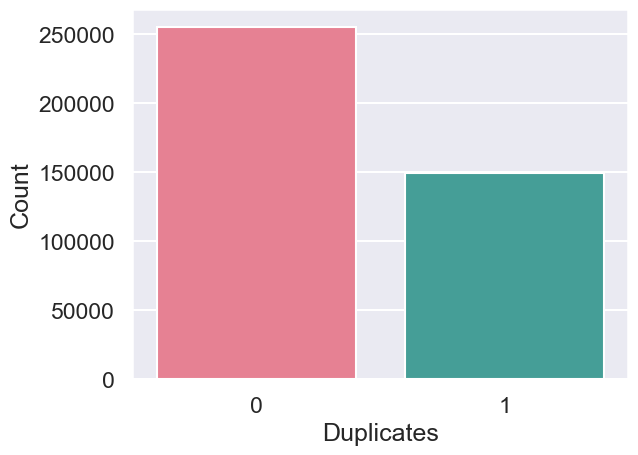

In [7]:
ax = sns.countplot(x='is_duplicate', data=df,palette="husl")
ax.set(xlabel="Duplicates", ylabel="Count")

plt.show()

The data in both categories is unbalanced.

In [65]:
print(round(len(df[df['is_duplicate']==1])/len(df)*100,2), "% of the questions are duplicate")


36.92 % of the questions are duplicate


### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [66]:
df.shape

(404290, 6)

In [117]:
#drop rows with blank values
df.dropna(inplace=True)
df.shape

(404287, 6)

In [118]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [119]:
#Remove unnecesary columns
df = df.drop(["id", "qid1", "qid2"],axis=1)
df = df.reset_index(drop=True)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404287 entries, 0 to 404286
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   question1     404287 non-null  object
 1   question2     404287 non-null  object
 2   is_duplicate  404287 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.3+ MB


In [120]:
#Prepare function for data cleaning
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
import re

#Apply Data Tokenization, lower case, filtering and lemmatization
def data_cleaning(df):
    df1 = df.copy()
    stop_words = set(stopwords.words('english'))
    punct = string.punctuation
    lemmatizer = nltk.WordNetLemmatizer()
    #Preprocess text
    def preprocess(text):
        # Remove any mathematical symbols or operators
        text = re.sub(r"[\^\/\*\+\-\=\(\)]", "", text)
        #Remove numbers
        text = re.sub(r"\d+", "", text)
        return text
    df1['question1_clean'] = df1['question1'].apply(lambda x:[lemmatizer.lemmatize(word) 
                                                              for word in word_tokenize(preprocess(x)) 
                                                              if word.lower() not in stop_words and word.lower() not in punct])
    df1['question2_clean'] = df1['question2'].apply(lambda x:[lemmatizer.lemmatize(word) 
                                                              for word in word_tokenize(preprocess(x)) 
                                                              if word.lower() not in stop_words and word.lower() not in punct])

    return df1

[nltk_data] Downloading package stopwords to /Users/hugo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/hugo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [121]:
df_clean =data_cleaning(df)
df_clean.head()

,question1,question2,is_duplicate,question1_clean,question2_clean
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]"
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, Kohinoor, KohiNoor, Diamond]","[would, happen, Indian, government, stole, Koh..."
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[Internet, speed, increased, hacking, DNS]"
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, solve]","[Find, remainder, math, math, divided]"
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]"


In [94]:
df_clean.to_csv("data/clean_data.csv",index=False)

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec


In [123]:
q1_str = []
q2_str = []
i = 0

while i < df_clean.shape[0]:
    q1_str.append(' '.join(df_clean.iloc[i,3]))
    q2_str.append(' '.join(df_clean.iloc[i,4]))
    i += 1

df_clean['q1_strs'] = q1_str
df_clean['q2_strs'] = q2_str

In [124]:
df_clean.head()

,question1,question2,is_duplicate,question1_clean,question2_clean,q1_strs,q2_strs
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",step step guide invest share market india,step step guide invest share market
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, Kohinoor, KohiNoor, Diamond]","[would, happen, Indian, government, stole, Koh...",story Kohinoor KohiNoor Diamond,would happen Indian government stole Kohinoor ...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[Internet, speed, increased, hacking, DNS]",increase speed internet connection using VPN,Internet speed increased hacking DNS
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, solve]","[Find, remainder, math, math, divided]",mentally lonely solve,Find remainder math math divided
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",one dissolve water quikly sugar salt methane c...,fish would survive salt water


In [125]:
#Create corpus for processing
corpus = pd.concat([df_clean['q1_strs'], df_clean['q2_strs']])

In [126]:
vectorized = TfidfVectorizer()
vectorized.fit(corpus)

TfidfVectorizer()

In [127]:
vectors_q1 = vectorized.transform(df_clean['q1_strs'])
vectors_q2 = vectorized.transform(df_clean['q2_strs'])

In [128]:
#cosine similarities ( how similar two vectors are in terms of their orientation, regardless of their magnitude. )

cosine_sim_list = []

for i in range(len(df_clean)):
       
        cosine_sim_list.append(cosine_similarity(vectors_q1[i], vectors_q2[i]))


In [129]:
#Calculate similarity
s = 0
cosine_sim = []

while s < df_clean.shape[0]:
    cosine_sim.append(cosine_sim_list[s][0][0])
    s += 1

In [130]:
#Similarity add
df_clean['cosine_sim'] = cosine_sim

In [131]:
tokenized_questions = [nltk.word_tokenize(q) for q in df_clean['q1_strs']] + [nltk.word_tokenize(q) for q in df_clean['q2_strs']]

In [132]:
# build word2vec model on the tokenized questions
model_2vec = Word2Vec(tokenized_questions, vector_size=100, window=5, min_count=1, workers=4)

#fill vector in df
df_clean['vectors_q1'] = df_clean['q1_strs'].apply(lambda x: np.array([model_2vec.wv[word] for word in nltk.word_tokenize(x)]))
df_clean['vectors_q2'] = df_clean['q2_strs'].apply(lambda x: np.array([model_2vec.wv[word] for word in nltk.word_tokenize(x)]))


In [133]:
df_clean.head()

,question1,question2,is_duplicate,question1_clean,question2_clean,q1_strs,q2_strs,cosine_sim,vectors_q1,vectors_q2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",step step guide invest share market india,step step guide invest share market,0.979549,"[[0.91260225, 0.9676495, 0.81735384, -0.796158...","[[0.91260225, 0.9676495, 0.81735384, -0.796158..."
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, Kohinoor, KohiNoor, Diamond]","[would, happen, Indian, government, stole, Koh...",story Kohinoor KohiNoor Diamond,would happen Indian government stole Kohinoor ...,0.795456,"[[-0.2827513, 1.2565242, 2.0358918, 0.24131177...","[[-0.04938468, 0.47403163, 0.58087647, -3.5461..."
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[Internet, speed, increased, hacking, DNS]",increase speed internet connection using VPN,Internet speed increased hacking DNS,0.276740,"[[0.32221344, 1.7719934, -0.69378376, 0.096604...","[[-1.4221587, 1.548298, -0.88279915, -0.644341..."
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, solve]","[Find, remainder, math, math, divided]",mentally lonely solve,Find remainder math math divided,0.000000,"[[0.3971746, 0.20117776, 0.8455034, 0.70874304...","[[-0.24212275, 0.16709076, 0.07774062, -0.1459..."
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",one dissolve water quikly sugar salt methane c...,fish would survive salt water,0.230158,"[[-0.25557578, -0.5976944, -0.20689987, -1.988...","[[1.4910619, 0.24330883, 0.51521, 0.33355138, ..."


In [134]:
df_clean['question1_word_count'] = df_clean['q1_strs'].apply(lambda x: len(word_tokenize(str(x)))) 
df_clean['question2_word_count'] = df_clean['q2_strs'].apply(lambda x: len(word_tokenize(str(x))))

In [135]:
df_clean.head()

,question1,question2,is_duplicate,question1_clean,question2_clean,q1_strs,q2_strs,cosine_sim,vectors_q1,vectors_q2,question1_word_count,question2_word_count
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",step step guide invest share market india,step step guide invest share market,0.979549,"[[0.91260225, 0.9676495, 0.81735384, -0.796158...","[[0.91260225, 0.9676495, 0.81735384, -0.796158...",7,6
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, Kohinoor, KohiNoor, Diamond]","[would, happen, Indian, government, stole, Koh...",story Kohinoor KohiNoor Diamond,would happen Indian government stole Kohinoor ...,0.795456,"[[-0.2827513, 1.2565242, 2.0358918, 0.24131177...","[[-0.04938468, 0.47403163, 0.58087647, -3.5461...",4,9
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[Internet, speed, increased, hacking, DNS]",increase speed internet connection using VPN,Internet speed increased hacking DNS,0.276740,"[[0.32221344, 1.7719934, -0.69378376, 0.096604...","[[-1.4221587, 1.548298, -0.88279915, -0.644341...",6,5
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, solve]","[Find, remainder, math, math, divided]",mentally lonely solve,Find remainder math math divided,0.000000,"[[0.3971746, 0.20117776, 0.8455034, 0.70874304...","[[-0.24212275, 0.16709076, 0.07774062, -0.1459...",3,5
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",one dissolve water quikly sugar salt methane c...,fish would survive salt water,0.230158,"[[-0.25557578, -0.5976944, -0.20689987, -1.988...","[[1.4910619, 0.24330883, 0.51521, 0.33355138, ...",10,5


In [136]:
#common words
df_clean['common_words'] = df_clean.apply (lambda x: list (set (x ['q1_strs'].split ()) & set (x ['q2_strs'].split ())), axis=1)
df_clean['common_count'] = df_clean['common_words'].apply (len)
df_clean.head()

,question1,question2,is_duplicate,question1_clean,question2_clean,q1_strs,q2_strs,cosine_sim,vectors_q1,vectors_q2,question1_word_count,question2_word_count,common_words,common_count
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",step step guide invest share market india,step step guide invest share market,0.979549,"[[0.91260225, 0.9676495, 0.81735384, -0.796158...","[[0.91260225, 0.9676495, 0.81735384, -0.796158...",7,6,"[invest, share, market, step, guide]",5
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, Kohinoor, KohiNoor, Diamond]","[would, happen, Indian, government, stole, Koh...",story Kohinoor KohiNoor Diamond,would happen Indian government stole Kohinoor ...,0.795456,"[[-0.2827513, 1.2565242, 2.0358918, 0.24131177...","[[-0.04938468, 0.47403163, 0.58087647, -3.5461...",4,9,"[Kohinoor, KohiNoor]",2
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[Internet, speed, increased, hacking, DNS]",increase speed internet connection using VPN,Internet speed increased hacking DNS,0.276740,"[[0.32221344, 1.7719934, -0.69378376, 0.096604...","[[-1.4221587, 1.548298, -0.88279915, -0.644341...",6,5,[speed],1
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, solve]","[Find, remainder, math, math, divided]",mentally lonely solve,Find remainder math math divided,0.000000,"[[0.3971746, 0.20117776, 0.8455034, 0.70874304...","[[-0.24212275, 0.16709076, 0.07774062, -0.1459...",3,5,[],0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",one dissolve water quikly sugar salt methane c...,fish would survive salt water,0.230158,"[[-0.25557578, -0.5976944, -0.20689987, -1.988...","[[1.4910619, 0.24330883, 0.51521, 0.33355138, ...",10,5,"[salt, water]",2


In [138]:
#df_clean.to_csv("data/after_feat_data.csv",index=False)

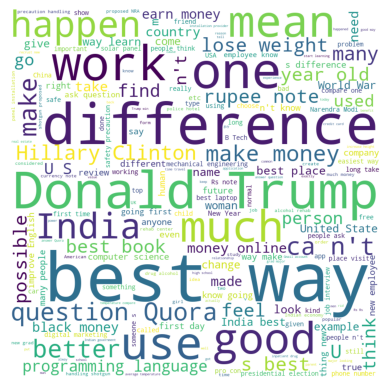

In [230]:
from wordcloud import WordCloud

df_clean['all_words']=df_clean['q1_strs'] +' '+ df_clean['q2_strs']
#Creating the text variable
text = " ".join(df_clean['all_words']) # join the words into a single string
wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(text)
plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [258]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#Balance sample
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [229]:
df_clean.head(2)

,question1,question2,is_duplicate,question1_clean,question2_clean,q1_strs,q2_strs,cosine_sim,vectors_q1,vectors_q2,question1_word_count,question2_word_count,common_words,common_count
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",step step guide invest share market india,step step guide invest share market,0.979549,"[[0.91260225, 0.9676495, 0.81735384, -0.796158...","[[0.91260225, 0.9676495, 0.81735384, -0.796158...",7,6,"[invest, share, market, step, guide]",5
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, Kohinoor, KohiNoor, Diamond]","[would, happen, Indian, government, stole, Koh...",story Kohinoor KohiNoor Diamond,would happen Indian government stole Kohinoor ...,0.795456,"[[-0.2827513, 1.2565242, 2.0358918, 0.24131177...","[[-0.04938468, 0.47403163, 0.58087647, -3.5461...",4,9,"[Kohinoor, KohiNoor]",2


In [148]:
#Create dataset for modeling
X = df_clean[['cosine_sim','question1_word_count','question2_word_count','common_count']]
y = df_clean['is_duplicate']

#Split test and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

In [165]:
X.head(2)

,cosine_sim,question1_word_count,question2_word_count,common_count
0,0.979549,7,6,5
1,0.795456,4,9,2


In [150]:
smote = SMOTE(random_state=1)
X_train_smote,y_train_smote = smote.fit_resample(X_train,y_train)

### Logistict Regression

In [151]:
lr_model = LogisticRegression()
lr_model.fit (X_train_smote,y_train_smote)

LogisticRegression()

In [152]:
y_pred = lr_model.predict(X_test)

In [245]:
#print(classification_report(y_test, y_pred))

print("Accuracy:",accuracy_score(y_test, y_pred))

#calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

auc_score = metrics.roc_auc_score(y_test, y_pred)
print("AUC score:", auc_score)

Accuracy: 0.6559895124786663
AUC score: 0.666604227828574


### XgBoost

In [238]:
import xgboost as xgb
from xgboost import XGBClassifier

xg_model = xgb.XGBClassifier(objective='binary:logistic',n_estimators=10, seed=13)

In [239]:
xg_model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [240]:
y_xg_pred = xg_model.predict(X_test)

In [242]:
#print(classification_report(y_test, xg_pred))

print("Accuracy:",accuracy_score(y_test, y_xg_pred))

#calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_xg_pred)

auc_score = metrics.roc_auc_score(y_test, y_xg_pred)
print("AUC score:", auc_score)

Accuracy: 0.6567439214425289
AUC score: 0.6973814143374932


In [160]:
# Hyper parameter tuning
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier()


In [161]:
#Commented to avoid execution again. It takes 144 minutes
#parameters = {'n_estimators': [100, 300, 500], 'max_depth': [10, 30, 50], 'learning_rate': [0.1, 0.01,0.2]}
#clf_xgb = GridSearchCV(xgb, parameters, cv=5)

#clf_xgb.fit(X_train_smote, y_train_smote)

# Print the best parameters
#print(clf_xgb.best_params_)

{'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 100}


In [167]:
xg_model_opt = xgb.XGBClassifier(objective='binary:logistic',learning_rate= 0.1, max_depth= 30,n_estimators=100, seed=13)

In [168]:
xg_model_opt.fit(X_train_smote, y_train_smote)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [243]:
y_xg_pred_opt = xg_model_opt.predict(X_test)

In [244]:
#print(classification_report(y_test, xg_pred_opt))
print("Accuracy:",accuracy_score(y_test, y_xg_pred_opt))

#calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_xg_pred_opt)

auc_score = metrics.roc_auc_score(y_test, y_xg_pred_opt)
print("AUC score:", auc_score)

Accuracy: 0.6714487125578175
AUC score: 0.6869241403577319
